**Embedding and VectorStore**

[ Raw Data (PDF) ] -- LlamaParse --> [ Extracted Text Llama Index Document Object ] -- LlamaIndex Core NodeParse --> [ Document object converted to Node Object by the process of Chunking ] -- HuggingFaceEmbedding --> [ Embedding of the Node Chunks ] -- DummyText --> [ VectorStore..dummy.. ]

In [1]:
# For LlamaIndex
!pip install llama-parse llama-index llama-index-embeddings-openai llama-index-embeddings-huggingface llama-index-vector-stores-chroma nltk

# For LangChain
!pip install langchain langchain-text-splitters langchain-community langchain-openai tiktoken
!pip install pypdf pymupdf pdfplumber unstructured chromadb

# Get Env Secret Key
!pip install python-dotenv

  Using cached pypdf-6.6.0-py3-none-any.whl.metadata (7.1 kB)
Using cached pypdf-6.6.0-py3-none-any.whl (328 kB)
  Attempting uninstall: pypdf
    Found existing installation: pypdf 5.9.0
    Uninstalling pypdf-5.9.0:
      Successfully uninstalled pypdf-5.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-readers-file 0.4.11 requires pypdf<6,>=5.1.0, but you have pypdf 6.6.0 which is incompatible.


In [2]:
from pprint import pprint

**Load Secret Key**

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # loads .env into environment variables

secret_key = os.getenv("LLAMA_CLOUD_API_KEY")


**PDF Document Parsing Using LLamaParse**

In [4]:
import os
from llama_parse import LlamaParse

# Initialize parser
parser = LlamaParse(
    result_type="markdown",  # or "text"
    verbose=True
)

# Parse PDF
documents = parser.load_data("/content/sample-local-pdf.pdf")
len(documents), type(documents), type(documents[0])

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


Started parsing the file under job_id bde8bd8e-af1d-4c70-a793-ab7e37777576


(3, list, llama_index.core.schema.Document)

In [5]:
pprint(dict(documents[0]))

{'audio_resource': None,
 'embedding': None,
 'excluded_embed_metadata_keys': [],
 'excluded_llm_metadata_keys': [],
 'id_': 'dcda1c26-fd93-4c4f-89ce-158365802e2f',
 'image_resource': None,
 'metadata': {},
 'metadata_separator': '\n',
 'metadata_template': '{key}: {value}',
 'relationships': {},
 'text_resource': MediaResource(embeddings=None, data=None, text='Sample PDF\nCreated for testing PDFObject\n\nThis PDF is three pages long. Three long pages. Or three short pages if you’re optimistic. Is it the same as saying “three long minutes”, knowing that all minutes are the same duration, and one cannot possibly be longer than the other? If these pages are all the same size, can one possibly be longer than the other?\n\nI digress. Here’s some Latin. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer nec odio. Praesent libero. Sed cursus ante dapibus diam. Sed nisi. Nulla quis sem at nibh elementum imperdiet. Duis sagittis ipsum. Praesent mauris. Fusce nec tellus sed augue 

**LlamaIndex Chunking Techniques**

LlamaIndex uses Node Parsers that convert Documents into Node objects, where each node is a chunk inheriting metadata from the parent document.

**SentenceSplitter**

In [6]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document, VectorStoreIndex

splitter = SentenceSplitter(
    chunk_size=512,        # Target tokens per chunk
    chunk_overlap=20,       # Overlap between chunks
    paragraph_separator="\n\n\n",
    secondary_chunking_regex="[^,.;。]+[,.;。]?"
)

In [7]:
nodes = splitter.get_nodes_from_documents(documents)

print(f"Nodes with Splitter: \nType: {type(nodes)}, \nNum_of_nodes: {len(nodes)}", end="\n\n")

pprint(dict(nodes[0]))

Nodes with Splitter: 
Type: <class 'list'>, 
Num_of_nodes: 7

{'embedding': None,
 'end_char_idx': 1605,
 'excluded_embed_metadata_keys': [],
 'excluded_llm_metadata_keys': [],
 'id_': '19f0f654-4d58-47eb-9d19-138fbbc80b6b',
 'metadata': {},
 'metadata_separator': '\n',
 'metadata_seperator': '\n',
 'metadata_template': '{key}: {value}',
 'mimetype': 'text/plain',
 'relationships': {<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='dcda1c26-fd93-4c4f-89ce-158365802e2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='92477fef8bfaa85668c659571b7bd25684c419d76f41bcbb48bb49adecc8082c'),
                   <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='d8e8d5d8-8d84-4fa7-980c-c2ad248ce458', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2d1c19aafc8ff88cd0f768565301acf72137baa59815d8afd988d1ea54a8a038')},
 'start_char_idx': 0,
 'text': 'Sample PDF\n'
         'Created for testing PDFObject\n'
         '\n'
         'This PDF is three pages long. Three long page

In [8]:
# Inspect nodes : nodes_with_splitter1
print(f"Total nodes created: {len(nodes)}")
print("\n=== First Node ===")
print(f"Node ID: {nodes[0].node_id}")
print(f"Text length: {len(nodes[0].text)} chars")
print(f"Metadata: {nodes[0].metadata}")
print(f"\nContent preview:\n{nodes[0].text[:300]}")


Total nodes created: 7

=== First Node ===
Node ID: 19f0f654-4d58-47eb-9d19-138fbbc80b6b
Text length: 1605 chars
Metadata: {}

Content preview:
Sample PDF
Created for testing PDFObject

This PDF is three pages long. Three long pages. Or three short pages if you’re optimistic. Is it the same as saying “three long minutes”, knowing that all minutes are the same duration, and one cannot possibly be longer than the other? If these pages are all


**Configure Embedding Model**

In [9]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


What happens:

Downloads the model: First time runs download BAAI/bge-small-en-v1.5 model (~134MB) from HuggingFace

Loads into memory: Model is loaded into Colab's RAM (not GPU unless specified)

Sets global config: Settings.embed_model makes this the default embedding model for all LlamaIndex operations

Model details:

Input: Text string (your chunk)

Output: 384-dimensional vector (list of 384 floats)

Each dimension: Represents abstract semantic features learned during training

In [10]:
# Example: What embedding looks like
text = "Machine learning is awesome"
embedding = Settings.embed_model.get_text_embedding(text)
print(f"Embedding dimensions: {len(embedding)}")  # 384
print(f"First 5 values: {embedding[:5]}")  # [0.0234, -0.156, 0.892, ...]


Embedding dimensions: 384
First 5 values: [-0.020707588642835617, -0.02103940211236477, 0.0031559825874865055, -0.028120256960392, 0.07308809459209442]


**Step 4: Create Vector Store**

In [11]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

# Initialize ChromaDB client
db = chromadb.PersistentClient(path="./chroma_db")


What happens:

Creates/opens a folder ./chroma_db on disk

Initializes SQLite database inside for metadata storage

Sets up file structure for storing vectors

In [12]:
# Create/get collection
chroma_collection = db.get_or_create_collection("free_rag")


What happens:

If collection doesn't exist: Creates new collection named "free_rag"

If exists: Loads existing collection (preserves previous data)

Collection structure: Think of it like a database table that will hold:

IDs: Unique identifier for each chunk

Embeddings: 384-dim vectors (one per chunk)

Documents: Original text of chunks

Metadata: Custom info (segment_type, page_number, etc.)

In [13]:
# Wrap in LlamaIndex format
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)


What happens:

Creates LlamaIndex wrapper around ChromaDB collection

This allows LlamaIndex to interact with ChromaDB using standard interface

Translation layer: LlamaIndex nodes ↔ ChromaDB documents

In [14]:
# Create storage context
storage_context = StorageContext.from_defaults(vector_store=vector_store)


What happens:

Creates a container that holds storage components

Contains:

vector_store: Where embeddings live (ChromaDB)

docstore: Where original documents stored

index_store: Metadata about indices

Used by VectorStoreIndex to know where to save data

**Step 5: Create Index and Generate Embeddings**

In [17]:
index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
    show_progress=True
)

Generating embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

What happens internally (this is the magic!):

**Phase 1: Embedding Generation**

For each node in nodes:
    1. Extract node.text (your chunk)
    2. Call Settings.embed_model.get_text_embedding(node.text)
    3. Get back 384-dim vector
    4. Attach to node.embedding property
    5. Show progress bar (if show_progress=True)

Example internal flow:
```python
# Pseudo-code of what VectorStoreIndex does
for node in nodes:
    # Get text
    text = node.text  # "Machine learning is..."
    
    # Generate embedding (calls HuggingFace model)
    embedding = Settings.embed_model.get_text_embedding(text)
    # Returns: [0.0234, -0.156, 0.892, ..., 0.445]  # 384 numbers
    
    # Attach to node
    node.embedding = embedding
```

Phase 2: Storage in ChromaDB

For each embedded node:
    1. Prepare data for ChromaDB:
       - id: node.node_id (UUID)
       - embedding: node.embedding (384 floats)
       - document: node.text (original text)
       - metadata: node.metadata (dict)
    
    2. Call vector_store.add(nodes)    
    3. ChromaDB stores:
       - Embedding vectors in optimized format
       - Text + metadata in SQLite
       - Creates HNSW index for fast similarity search

What's stored in ChromaDB:
```
Collection: "free_rag"
├── Document 1
│   ├── ID: "515c17b1-06a6-4245..."
│   ├── Embedding: [0.023, -0.156, ..., 0.445]  # 384 floats
│   ├── Document: "Sample PDF\nCreated for testing..."
│   └── Metadata: {"segment_type": "text", "segment_index": 0}
├── Document 2
│   ├── ID: "a2f8c3d9-1234-5678..."
│   ├── Embedding: [0.412, 0.234, ..., -0.123]
│   ├── Document: "def binary_search(arr, target):\n..."
│   └── Metadata: {"segment_type": "code", "language": "python"}
└── ... (continues for all nodes)
```


**How to Inspect and Visualize Vector Store**

1. Basic Inspection: View Stored Data


In [18]:
# ===== Inspect ChromaDB Collection =====

# Get collection stats
print(f"Total documents in collection: {chroma_collection.count()}")

# Peek at first few documents
peek_data = chroma_collection.peek(limit=3)
print(f"\nKeys in peek data: {peek_data.keys()}")
# Output: dict_keys(['ids', 'embeddings', 'documents', 'metadatas'])

# View first document
print(f"\n=== First Document ===")
print(f"ID: {peek_data['ids'][0]}")
print(f"Document text: {peek_data['documents'][0][:200]}...")
print(f"Metadata: {peek_data['metadatas'][0]}")
print(f"Embedding (first 10 dims): {peek_data['embeddings'][0][:10]}")
print(f"Embedding dimensions: {len(peek_data['embeddings'][0])}")


Total documents in collection: 7

Keys in peek data: dict_keys(['ids', 'embeddings', 'documents', 'uris', 'included', 'data', 'metadatas'])

=== First Document ===
ID: 19f0f654-4d58-47eb-9d19-138fbbc80b6b
Document text: Sample PDF
Created for testing PDFObject

This PDF is three pages long. Three long pages. Or three short pages if you’re optimistic. Is it the same as saying “three long minutes”, knowing that all min...
Metadata: {'doc_id': 'dcda1c26-fd93-4c4f-89ce-158365802e2f', 'document_id': 'dcda1c26-fd93-4c4f-89ce-158365802e2f', '_node_content': '{"id_": "19f0f654-4d58-47eb-9d19-138fbbc80b6b", "embedding": null, "metadata": {}, "excluded_embed_metadata_keys": [], "excluded_llm_metadata_keys": [], "relationships": {"1": {"node_id": "dcda1c26-fd93-4c4f-89ce-158365802e2f", "node_type": "4", "metadata": {}, "hash": "92477fef8bfaa85668c659571b7bd25684c419d76f41bcbb48bb49adecc8082c", "class_name": "RelatedNodeInfo"}, "3": {"node_id": "d8e8d5d8-8d84-4fa7-980c-c2ad248ce458", "node_type": 

2. Get All Documents from Collection


In [19]:
# Get ALL documents (be careful with large collections)
all_data = chroma_collection.get(
    include=['embeddings', 'documents', 'metadatas']
)

print(f"\nTotal documents retrieved: {len(all_data['ids'])}")

# Analyze by content type
from collections import Counter

segment_types = [meta.get('segment_type', 'unknown')
                 for meta in all_data['metadatas']]
type_counts = Counter(segment_types)

print(f"\n=== Content Type Distribution ===")
for content_type, count in type_counts.items():
    print(f"{content_type}: {count}")

# View specific document by ID
specific_doc = chroma_collection.get(
    ids=["515c17b1-06a6-4245-b96b-d3a32adb1560"]
)
print(f"\n=== Specific Document ===")
print(specific_doc)



Total documents retrieved: 7

=== Content Type Distribution ===
unknown: 7

=== Specific Document ===
{'ids': [], 'embeddings': None, 'documents': [], 'uris': None, 'included': ['metadatas', 'documents'], 'data': None, 'metadatas': []}


3. Query Vector Store (Test Similarity Search)


In [20]:
# Test semantic search
query_text = "How to implement binary search?"

# Query collection
results = chroma_collection.query(
    query_texts=[query_text],
    n_results=3,  # Top 3 most similar
    include=['documents', 'metadatas', 'distances', 'embeddings']
)

print(f"\n=== Query Results ===")
print(f"Query: {query_text}\n")

for i in range(len(results['ids'][0])):
    print(f"--- Result {i+1} ---")
    print(f"Distance: {results['distances'][0][i]:.4f}")  # Lower = more similar
    print(f"Document: {results['documents'][0][i][:200]}...")
    print(f"Metadata: {results['metadatas'][0][i]}\n")


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 42.9MiB/s]



=== Query Results ===
Query: How to implement binary search?

--- Result 1 ---
Distance: 1.9437
Document: ipsum dolor sit amet, consectetur adipiscing elit. Integer nec odio. Praesent libero. Sed cursus ante dapibus diam. Sed nisi. Nulla quis sem at nibh elementum imperdiet. Duis sagittis ipsum. Praesent ...
Metadata: {'doc_id': '17ee840e-59f7-4b19-bad6-c9120224d81c', 'ref_doc_id': '17ee840e-59f7-4b19-bad6-c9120224d81c', 'document_id': '17ee840e-59f7-4b19-bad6-c9120224d81c', '_node_type': 'TextNode', '_node_content': '{"id_": "32536185-7cec-4a7c-9966-0a0a68f184a3", "embedding": null, "metadata": {}, "excluded_embed_metadata_keys": [], "excluded_llm_metadata_keys": [], "relationships": {"1": {"node_id": "17ee840e-59f7-4b19-bad6-c9120224d81c", "node_type": "4", "metadata": {}, "hash": "128eebefa6547661e80785b7a8c983dc56573ca48554459f312d6d93f9950fec", "class_name": "RelatedNodeInfo"}, "3": {"node_id": "37d009b2-765b-47e0-9472-afd955710f42", "node_type": "1", "metadata": {}, "hash": "0a7

4. Visualize Embeddings in 2D (Advanced)

Now let's visualize your high-dimensional embeddings in 2D space:


In [22]:
!pip install umap-learn scikit-learn matplotlib seaborn


Embedding matrix shape: (7, 384)

Running UMAP dimensionality reduction...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


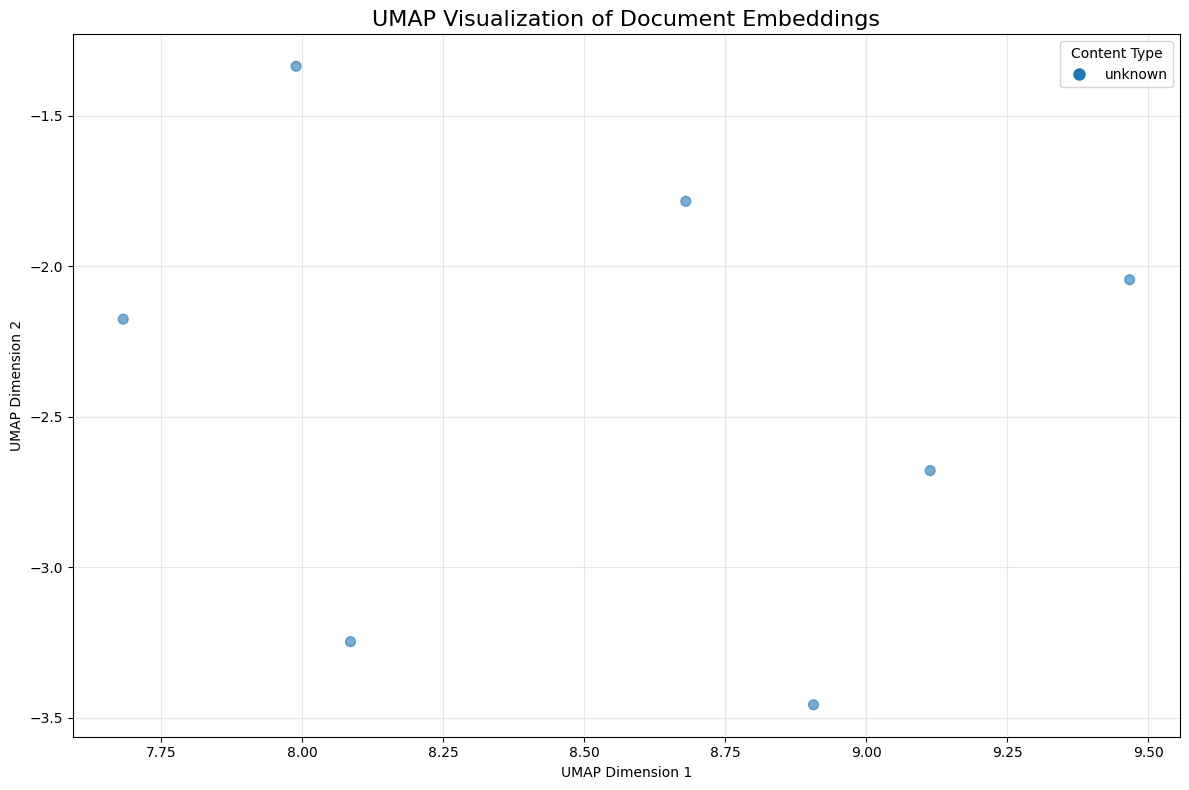

✅ Visualization saved as 'embeddings_umap.png'


In [23]:
# Install visualization libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap

# ===== Get all embeddings from ChromaDB =====
all_data = chroma_collection.get(
    include=['embeddings', 'metadatas', 'documents']
)

embeddings_array = np.array(all_data['embeddings'])
metadatas = all_data['metadatas']
documents = all_data['documents']

print(f"Embedding matrix shape: {embeddings_array.shape}")
# Output: (num_chunks, 384)

# ===== Method 1: UMAP (Faster, better for large datasets) =====
print("\nRunning UMAP dimensionality reduction...")

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

embeddings_2d = umap_model.fit_transform(embeddings_array)

# Create labels from metadata
labels = [meta.get('segment_type', 'unknown') for meta in metadatas]

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=[labels.index(label) for label in labels],
    cmap='tab10',
    alpha=0.6,
    s=50
)

# Add legend
unique_labels = list(set(labels))
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=plt.cm.tab10(i/len(unique_labels)),
                      markersize=10, label=label)
          for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title="Content Type")

plt.title("UMAP Visualization of Document Embeddings", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("embeddings_umap.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved as 'embeddings_umap.png'")


5. Interactive Visualization with Hover Text


In [24]:
# Interactive plot with document previews
import plotly.express as px
import pandas as pd

# Prepare data
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'type': labels,
    'text_preview': [doc[:100] + "..." for doc in documents],
    'length': [len(doc) for doc in documents]
})

# Create interactive plot
fig = px.scatter(
    df,
    x='x',
    y='y',
    color='type',
    hover_data=['text_preview', 'length'],
    title='Interactive Embedding Visualization',
    labels={'x': 'UMAP-1', 'y': 'UMAP-2'},
    width=1000,
    height=700
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()


6. t-SNE Visualization (Alternative)



Running t-SNE dimensionality reduction...


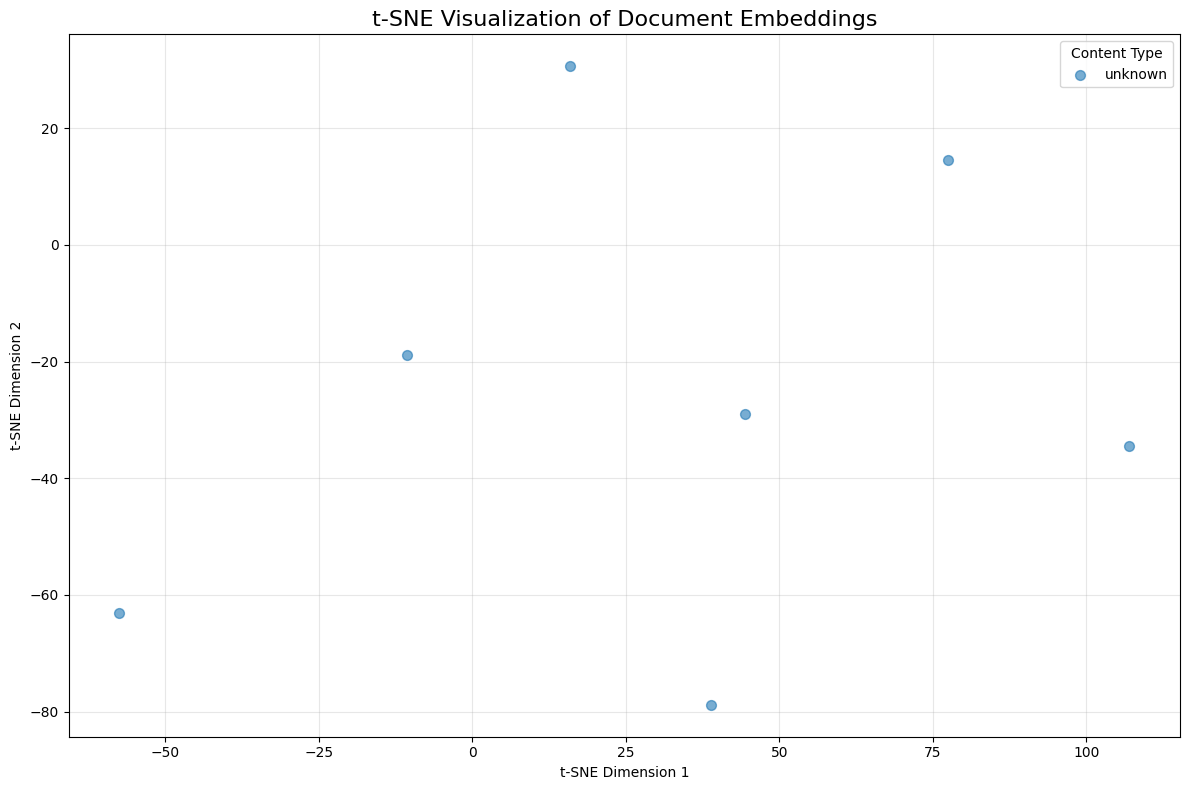

In [26]:
# ===== Method 2: t-SNE (Better for local structure) =====
print("\nRunning t-SNE dimensionality reduction...")

tsne = TSNE(
    n_components=2,
    perplexity=5, # Changed from 30 to 5, as n_samples is 7 (must be < n_samples)
    max_iter=1000, # Changed from n_iter to max_iter
    random_state=42
)

embeddings_2d_tsne = tsne.fit_transform(embeddings_array)

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(set(labels)):
    mask = np.array(labels) == label
    plt.scatter(
        embeddings_2d_tsne[mask, 0],
        embeddings_2d_tsne[mask, 1],
        label=label,
        alpha=0.6,
        s=50
    )

plt.legend(title="Content Type")
plt.title("t-SNE Visualization of Document Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("embeddings_tsne.png", dpi=300, bbox_inches='tight')
plt.show()

7. Analyze Embedding Clusters


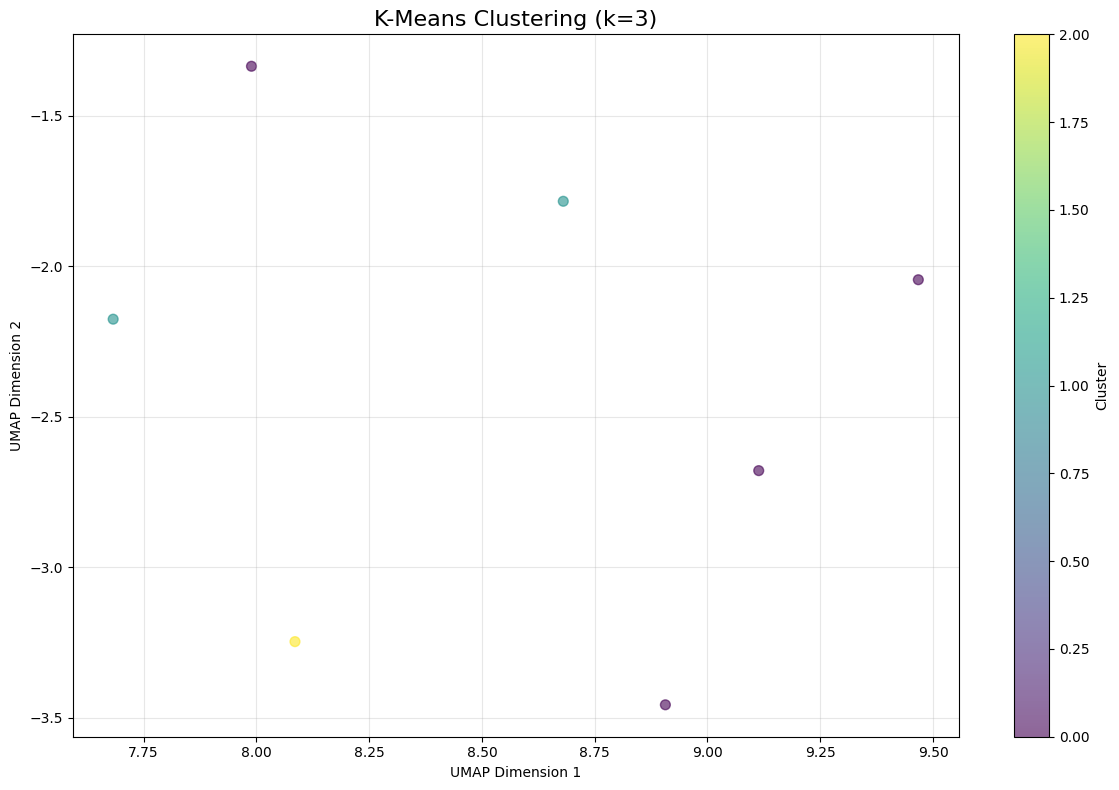


=== Cluster Analysis ===

Cluster 0 (4 documents):
Sample: ipsum dolor sit amet, consectetur adipiscing elit. Integer nec odio. Praesent libero. Sed cursus ant...

Cluster 1 (2 documents):
Sample: Vestibulum sapien. Proin quam. Etiam ultrices.

Suspendisse in justo eu magna luctus suscipit. Sed l...

Cluster 2 (1 documents):
Sample: Sample PDF
Created for testing PDFObject

This PDF is three pages long. Three long pages. Or three s...


In [27]:
from sklearn.cluster import KMeans

# Cluster embeddings
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.6,
    s=50
)
plt.colorbar(scatter, label='Cluster')
plt.title(f"K-Means Clustering (k={n_clusters})", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze clusters
print("\n=== Cluster Analysis ===")
for i in range(n_clusters):
    cluster_docs = [documents[j][:100] for j, label in enumerate(cluster_labels) if label == i]
    print(f"\nCluster {i} ({sum(cluster_labels == i)} documents):")
    print(f"Sample: {cluster_docs[0]}...")


8. Complete Inspection Dashboard


In [28]:
def create_vector_store_dashboard(chroma_collection):
    """Complete inspection dashboard for your vector store"""

    print("="*80)
    print(" VECTOR STORE INSPECTION DASHBOARD ".center(80))
    print("="*80)

    # Basic stats
    count = chroma_collection.count()
    print(f"\n📊 Total Documents: {count}")

    # Get all data
    all_data = chroma_collection.get(include=['embeddings', 'metadatas'])

    # Embedding stats
    embeddings = np.array(all_data['embeddings'])
    print(f"🔢 Embedding Dimensions: {embeddings.shape[1]}")
    print(f"📏 Embedding Stats:")
    print(f"   Mean: {embeddings.mean():.4f}")
    print(f"   Std:  {embeddings.std():.4f}")
    print(f"   Min:  {embeddings.min():.4f}")
    print(f"   Max:  {embeddings.max():.4f}")

    # Metadata analysis
    metadatas = all_data['metadatas']

    # Content type distribution
    types = [m.get('segment_type', 'unknown') for m in metadatas]
    type_counts = Counter(types)

    print(f"\n📁 Content Type Distribution:")
    for content_type, count in type_counts.most_common():
        percentage = (count / len(types)) * 100
        bar = "█" * int(percentage / 2)
        print(f"   {content_type:15s}: {count:4d} ({percentage:5.1f}%) {bar}")

    # Language distribution (for code)
    languages = [m.get('code_language', 'N/A') for m in metadatas
                 if 'code_language' in m]
    if languages:
        lang_counts = Counter(languages)
        print(f"\n💻 Code Languages:")
        for lang, count in lang_counts.most_common():
            print(f"   {lang}: {count}")

    print("\n" + "="*80)

# Run dashboard
create_vector_store_dashboard(chroma_collection)


                       VECTOR STORE INSPECTION DASHBOARD                        

📊 Total Documents: 7
🔢 Embedding Dimensions: 384
📏 Embedding Stats:
   Mean: 0.0003
   Std:  0.0510
   Min:  -0.3603
   Max:  0.4280

📁 Content Type Distribution:
   unknown        :    7 (100.0%) ██████████████████████████████████████████████████

